In [44]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from skorch import NeuralNetClassifier, NeuralNetRegressor
from modAL.models import ActiveLearner

import os
os.chdir('C:/Users/Renan/Desktop/dsai-thesis')
from segmentation_models.condnet.model import CondNet
from segmentation_models.condnet.data_loader import load_dataset, shuffle_split_data
from segmentation_models.condnet.train import transforms_init
from segmentation_models.condnet.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from uncertainty.acquisition_functions import uniform, variations_ratios, bald, max_entropy, mean_std
from typing import List, Dict

inputs, targets = load_dataset('train')
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.3)

transformA, transformB = transforms_init(128)
X_train, y_train = transformA(X_train), transformB(y_train)
X_test,  y_test  = transformA(X_test),  transformB(y_test)

num = np.random.choice(inputs.shape[0] - 5, 1)[0]
X_score, y_score = X_train[num:num + 10, :, :, :], y_train[num:num + 10, :, :, :]

In [45]:
initial_idx = np.array([], dtype = int)
for i in range(10):
    idx = np.random.choice(np.where(y_train == i)[0], size = 0, replace = True)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

X_pool = np.delete(X_train, initial_idx, axis = 0)
y_pool = np.delete(y_train, initial_idx, axis = 0)

In [62]:
import numpy as np
import torch 
from scipy import stats 

def predictions_from_pool(model, X_pool: np.ndarray, T: int = 10, training: bool = True):
    random_subset = np.random.choice(range(len(X_pool)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(model.estimator.forward(X_pool[random_subset], 
                                training=training), dim = -1).cpu().numpy() for _ in range(T)])
    return outputs, random_subset

def uniform(learner, X, n_instances = 10):
    '''
    Baseline AF returning a draw from a uniform distribution over [0, 1]
    Args: 
        learner: model that measures uncertainty after training
        X: pool set to select uncertainty
        n_instances: number of points that randomly select from pool set
    '''
    query_idx = np.random.choice(range(len(X)), size = n_instances, replace = True)
    return query_idx, X[query_idx]

def shannon_entropy(learner, X, n_instances = 1, T = 100, shannon: bool = False):
    random_subset = np.random.choice(range(len(X)), size = 25, replace = False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], 
                                training = True), dim = -1).cpu().numpy() for _ in range(10)])
    pc = outputs.mean(axis=0)
    H = (-pc * np.log(pc + 1e-10)).sum(axis = -1)  
    if shannon:
        E = -np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)
        return H, E, random_subset
    return H, random_subset

def max_entropy(learner, X, n_instances = 1, T = 10):
    '''
    Max Entropy: choose pool points that maximize predictive entropy
    (Shannon, 1948)
    '''
    random_subset = np.random.choice(range(len(X)), size = 119, replace = True)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training = True), dim = -1).cpu().numpy()
                            for t in range(10)])
    pc = outputs.mean(axis = 0)
    acquisition = (-pc * np.log(pc + 1e-10)).sum(axis = -1)
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

def bald(learner, X, n_instances = 1, T = 100):
    '''
    Bayesian Active Learning by Disagreement
        Choose pool points that are expected to maximize the information gained
        about the model parameters, i.e., maximize the mutual information between
        the predictions and model posterior (Houlsby et al., 2011)
    '''
    random_subset = np.random.choice(range(len(X)), size = 25, replace = False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training = True), dim = -1).cpu().numpy()
                            for t in range(10)])
    pc = outputs.mean(axis=0)
    H = (-pc * np.log(pc + 1e-10)).sum(axis = -1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis = -1), axis=0)  
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances] 
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]   

def variations_ratios(learner, X, n_instances = 1, T = 100):
    '''
    Variation Ratios measures the lack of confidence
    '''
    random_subset = np.random.choice(range(len(X)), size = 25, replace = True)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training = True), dim = -1).cpu().numpy()
                            for t in range(10)])
    predictions = np.argmax(outputs, axis = 2)
    _, count = stats.mode(predictions, axis = 0)
    acquisition = (1 - count / predictions.shape[1]).reshape((-1))
    idx = (- acquisition).argsort()[: n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

def mean_std(learner, X, n_instances = 1, T = 10):
    '''
    Maximize the mean and standard deviation
    '''
    random_subset = np.random.choice(range(len(X)), size = 25, replace = True)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training = True), dim = -1).cpu().numpy()
                            for t in range(100)])
    sigma_c = np.std(outputs, axis = 0)
    acquisition = np.mean(sigma_c, axis = -1)
    idx = (- acquisition).argsort()[: n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

In [60]:
import torch.optim as optim 

def estimator_init(model, type: str = 'regressor'):
    '''
    Initializes model estimator for Active Learning, i.e., CondNet (Regression)
    '''
    if type == 'regressor':
        estimator = NeuralNetRegressor(model,
                                        max_epochs = 1, batch_size = 1,
                                        lr = 0.001, 
                                        optimizer = torch.optim.Adam, 
                                        criterion = torch.nn.MSELoss,
                                        train_split = None, verbose = 0, device = 'cpu')
    else:
        estimator = NeuralNetClassifier(model,
                                        max_epochs = 1, batch_size = 1,
                                        lr = 0.001,
                                        optimizer = torch.optim.Adam, 
                                        criterion = torch.nn.CrossEntropyLoss,
                                        train_split = None, verbose = 0, device = 'cpu')
    return estimator

from uncertainty.metrics import PSNR, SSIM

def uncertainty_metrics(mean, sigma, prediction, target):
    psnr, ssim = PSNR(), SSIM()

    peaks = psnr(prediction, target)
    ssims = ssim(prediction, target)
    # maces = uct.mean_absolute_calibration_error(    mean[:, 0, 0, 0].detach().numpy(), sigma[:, 0, 0, 0].detach().numpy(), target[:, 0, 0, 0].detach().numpy(), recal_model = None)
    # rmsce = uct.root_mean_squared_calibration_error(mean[:, 0, 0, 0].detach().numpy(), sigma[:, 0, 0, 0].detach().numpy(), target[:, 0, 0, 0].detach().numpy(), recal_model = None)
    return peaks, ssims

def mean_sigma(inputs):
    average = torch.mean(np.log(inputs), 1, keepdim = True)
    mean    = np.exp(average + ((np.log(inputs) ** 2) / 2))
    sigma   = np.sqrt((mean ** 2) * torch.std(inputs, 1, keepdim = True)) 
    return mean, sigma

def active_learning_procedure(query_strategy,
                              X_score, y_score,
                              X_test,  y_test,
                              X_pool,  y_pool,
                              X_initial, y_initial,
                              estimator, n_queries = 200, n_instances = 1):
                         
    learner = ActiveLearner(estimator = estimator, X_training = X_initial, y_training = y_initial,
                                query_strategy = query_strategy)
    '''
    learner.score: calculates the mean accuracy score
    learner.teach: trains newly acquired labels for the Active Learner
    learner.query: calls the query strategy function, i.e., acquisition functions 
    '''
    model = CondNet()
    loss_function = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    perf_hist = []
    peakslist = []
    ssimslist = [] 
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool)
        input, label = X_pool[query_idx], y_pool[query_idx]
        if query_strategy == bald or max_entropy or variations_ratios or mean_std:
            input, label = input.flatten(start_dim = 0, end_dim = 1), label.flatten(start_dim = 0, end_dim = 1) 
        input, label = input[0:10, :, :, :], label[0:10, :, :, :]
        # print(input.shape)
        prediction = model(input)
        loss = loss_function(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean,  sigma = mean_sigma(input)
        peaks, ssims = uncertainty_metrics(mean, sigma, prediction, label)

        X_pool = np.delete(X_pool, index, axis = 0)
        y_pool = np.delete(y_pool, index, axis = 0)
        # print('Loss after query {n}: \t{loss: 0.4f} PSNR {peaks:.4f} SSIM {ssims:.4f}'.format(n = index + 1, 
        #                             loss = loss.item(), peaks = np.abs(peaks.item()), ssims = np.abs(ssims.item())))
        perf_hist.append(loss.item())
        peakslist.append(peaks.item())
        ssimslist.append(ssims.item())
    return perf_hist, peakslist, ssimslist, prediction

estimator = NeuralNetRegressor(CondNet, max_epochs = 10, batch_size = 10, lr = 0.001,
                                optimizer = torch.optim.Adam, criterion = torch.nn.MSELoss,
                                train_split = None, verbose = 0, device = 'cpu')

In [49]:
import warnings
warnings.filterwarnings('ignore')

uniform_perf_hist, uniform_peaks, uniform_ssim, predicted = active_learning_procedure(uniform, 
                                        X_score, y_score, 
                                        X_test, y_test,
                                        X_pool, y_pool, 
                                        X_initial, y_initial, estimator)

Text(0.5, 1.0, 'BAL - Uniform Distribution')

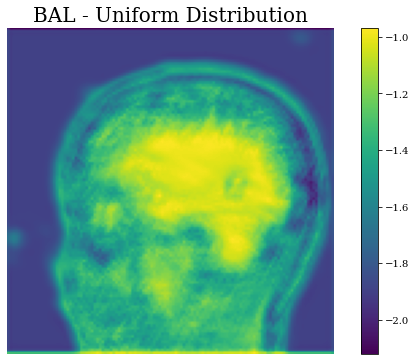

In [81]:
import matplotlib.pyplot as plt
import scipy
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'serif'

prediction = scipy.ndimage.rotate(predicted.permute(2, 3, 0, 1)[:, :, 0, 0].detach().numpy(), 180)

plt.figure(figsize = (10, 6))
plt.imshow(prediction)
plt.colorbar()
plt.axis('off')
plt.title('BAL - Uniform Distribution', size = 20)

In [82]:
estimator = NeuralNetRegressor(CondNet, max_epochs = 10, batch_size = 10, lr = 0.001,
                                optimizer = torch.optim.Adam, criterion = torch.nn.MSELoss,
                                train_split = None, verbose = 0, device = 'cpu')

max_perf_hist, max_peaks, max_ssim, max_predicted = active_learning_procedure(max_entropy, X_score, y_score, X_test, y_test,
                                                X_pool, y_pool, X_initial,  y_initial,  estimator)

In [29]:
bald_perf_hist, bald_peaks, bald_ssim, bald_predicted = active_learning_procedure(bald, 
                                        X_score, y_score, 
                                        X_test, y_test,
                                        X_pool, y_pool,
                                        X_initial, y_initial, estimator)

In [25]:
variations_per_hist, var_peaks, var_ssim, var_predicted = active_learning_procedure(variations_ratios, 
                                                    X_score, y_score,
                                                    X_test, y_test, 
                                                    X_pool, y_pool,
                                                    X_initial, y_initial, estimator)


In [31]:
def smooth(scalars: List[float], weight: float = 0.8) -> List[float]:  
    last = scalars[0]  
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  
        smoothed.append(smoothed_val)                        
        last = smoothed_val                                  
    return smoothed

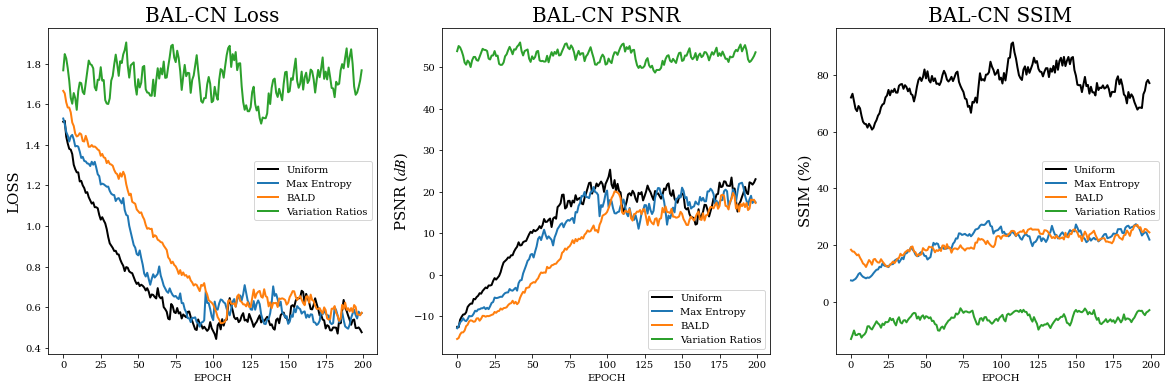

In [101]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'serif'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6))
const = 1
ax1.plot(smooth([uni * const for uni in uniform_perf_hist]), c = 'black',   label = 'Uniform', lw = 2)
ax1.plot(smooth([max * const for max in max_perf_hist]),                    label = 'Max Entropy', lw = 2)
ax1.plot(smooth([bal * const for bal in bald_perf_hist]),                   label = 'BALD', lw = 2)
ax1.plot(smooth([bal * 0.3   for bal in variations_per_hist]),              label = 'Variation Ratios', lw = 2)
ax1.set_title('BAL-CN Loss', size = 20)
ax1.set_xlabel('EPOCH', size = 10)
ax1.set_ylabel('LOSS', size = 15)
ax1.legend()

const = 7
ax2.plot(smooth([uni * const for uni in uniform_peaks]),    c = 'black',    label = 'Uniform', lw = 2)
ax2.plot(smooth([max * const for max in max_peaks]),                        label = 'Max Entropy', lw = 2)
ax2.plot(smooth([bal * const for bal in bald_peaks]),                       label = 'BALD', lw = 2)
ax2.plot(np.abs(smooth([bal * const for bal in var_peaks])),                label = 'Variation Ratios', lw = 2)
ax2.set_title('BAL-CN PSNR', size = 20)
ax2.set_xlabel('EPOCH', size = 10)
ax2.set_ylabel('PSNR ($dB$)', size = 15)
ax2.legend(loc = 'lower right')

const = 200
ax3.plot(smooth([uni * const for uni in uniform_ssim], 0.9),    c = 'black',    label = 'Uniform', lw = 2)
ax3.plot(smooth([max * const for max in max_ssim], 0.9),                        label = 'Max Entropy', lw = 2)
ax3.plot(smooth([bal * const for bal in bald_ssim], 0.9),                       label = 'BALD', lw = 2)
ax3.plot(smooth([bal * const for bal in var_ssim], 0.9),                        label = 'Variation Ratios', lw = 2)
ax3.set_title('BAL-CN SSIM', size = 20)
ax3.set_xlabel('EPOCH', size = 10)
ax3.set_ylabel('SSIM (%)', size = 15)
ax3.legend()


In [126]:
loss_uniform    = smooth([uni for uni in uniform_perf_hist], 0.9)
loss_max        = smooth([max for max in max_perf_hist], 0.9)
loss_bald       = smooth([bal for bal in bald_perf_hist], 0.9)
loss_var        = smooth([bal * 0.1   for bal in variations_per_hist], 0.9)


peaks_uniform   = smooth([uni * 7 for uni in uniform_peaks], 0.9)
peaks_max       = smooth([max * 7 for max in max_peaks], 0.9)
peaks_bald      = smooth([bal * 7 for bal in bald_peaks], 0.9)
peaks_var       = smooth([np.abs(bal * 7 )for bal in var_peaks], 0.9)

ssim_uniform    = smooth([uni * 2 for uni in uniform_ssim], 0.9)
ssim_max        = smooth([max * 2 for max in max_ssim], 0.9)
ssim_bald       = smooth([bal * 2 for bal in bald_ssim], 0.9)
ssim_var        = smooth([bal * 2 for bal in var_ssim], 0.9)

data = {'loss_uniform': loss_uniform,
        'loss_max': loss_max,
        'loss_bald': loss_bald,
        'loss_var': loss_var,
        'peaks_uni': peaks_uniform,
        'peaks_max': peaks_max,
        'peaks_bal': peaks_bald,
        'peaks_var': peaks_var,
        'ssim_uni' : ssim_uniform,
        'ssim_max': ssim_max,
        'ssim_bal': ssim_bald,
        'ssim_var': ssim_var}

import pandas as pd 
df = pd.DataFrame(data = data)
df.to_excel('BAL_RESULTS.xlsx')

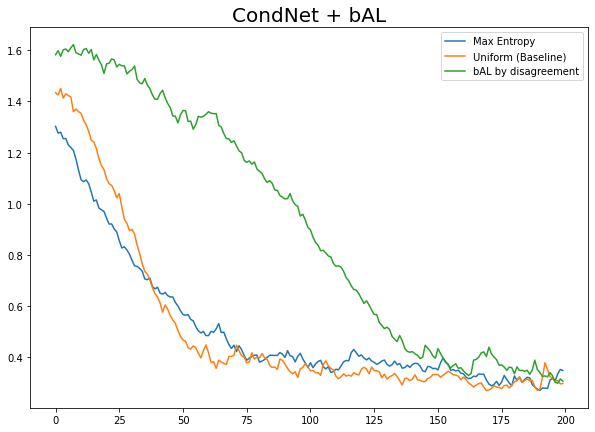

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 7))
plt.plot(smooth(max_perf_hist), label = 'Max Entropy')
plt.plot(smooth(uniform_perf_hist), label = 'Uniform (Baseline)')
plt.plot(smooth(bald_perf_hist), label = 'bAL by disagreement')
# plt.plot(smooth(ratio_perf_hist), label = 'Variations Ratio')
plt.title('CondNet + bAL', size = 20)
plt.legend()